<a href="https://colab.research.google.com/github/Luisamfer/Ativ_Est_Desc/blob/main/Estat_desc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INFORMAÇÕES DO CADASTRO NACIONAL DA AGRICULTURA FAMILIAR#
#**Definição da população**#
#*População Acessível*: Agricultores Familiares que realizaram o Cadastro Nacional da Agricultura Familiar#
#*Objetivo do estudo*: Caracterizar os agricultores familiares cadastrados, permitindo verificação posterior quanto a relação entre e perfil de agricultores e produção #


In [2]:
# Importando as bibliotecas necessárias para análises
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statistics as st
from datetime import datetime

In [3]:
# Importando o arquivo pelo Google Drive
from google.colab import drive

# Carregando arquivos
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Carregando o arquivo de MEMBROS da UFPA
df_membros = pd.read_csv("/content/drive/My Drive/Colab Notebooks/MBA_Est_Desc_dados/MEMBROS.csv", sep=';', encoding='utf-8', dtype={
    "CAF":"string",
    "CODIGO_PESSOA":"string",
    "SEXO":"category",
    "ESCOLARIDADE":"category",
    "MAO_DE_OBRA_FAMILIAR":"category"
    })

### Tendo em vista que já conheço o banco de dados e suas variáveis, já identifiquei os formatos necessários na importação. ###

# Verificando se os dados foram importados corretamente (quantidade e formatos)
df_membros.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4535543 entries, 0 to 4535542
Data columns (total 6 columns):
 #   Column                Dtype   
---  ------                -----   
 0   CAF                   string  
 1   CODIGO_PESSOA         string  
 2   SEXO                  category
 3   DATA_NASCIMENTO       object  
 4   ESCOLARIDADE          category
 5   MAO_DE_OBRA_FAMILIAR  category
dtypes: category(3), object(1), string(2)
memory usage: 116.8+ MB


In [5]:
# Convertendo a variável DATA_NASCIMENTO para formato datetime
df_membros["DATA_NASCIMENTO"] = pd.to_datetime(df_membros["DATA_NASCIMENTO"], dayfirst=True, errors='coerce')

# Calculando a idade de cada MEMBRO da UFPA
hoje = datetime.today()
df_membros["IDADE"] = df_membros["DATA_NASCIMENTO"].apply(lambda x: int(hoje.year - x.year - ((hoje.month, hoje.day) < (x.month, x.day))) if pd.notnull(x) else None)

#Visualizando a criação da nova variável
df_membros.head()

#Obtendo resumo estatístico da base importada
df_membros.describe()

,DATA_NASCIMENTO,IDADE
count,4535543,4.535543e+06
mean,1982-11-09 22:08:21.858498432,4.182512e+01
min,1909-05-19 00:00:00,0.000000e+00
25%,1968-09-11 00:00:00,2.800000e+01
50%,1981-06-23 00:00:00,4.300000e+01
75%,1996-09-19 00:00:00,5.600000e+01
max,2025-02-13 00:00:00,1.150000e+02
std,NaN,1.837484e+01


In [6]:
#Criando a variável FAIXA ETÁRIA para melhor classificação das idades.
def definir_faixa_etaria(IDADE):
  if IDADE <= 15:
    return "Menor de 15 anos"
  elif IDADE <= 29:
    return "16 a 29 anos"
  elif IDADE <= 39:
    return "30 a 39 anos"
  elif IDADE <= 49:
    return "40 a 49 anos"
  elif IDADE <= 59:
    return "50 a 59 anos"
  elif IDADE <= 69:
    return "60 a 69 anos"
  elif IDADE <= 79:
    return "70 a 79 anos"
  elif IDADE <= 89:
    return "80 a 89 anos"
  elif IDADE > 89:
    return "Mais de 90 anos"

  return pd.NA

df_membros['FAIXA_ETARIA'] = df_membros["IDADE"].apply(definir_faixa_etaria)
df_membros.head()

,CAF,CODIGO_PESSOA,SEXO,DATA_NASCIMENTO,ESCOLARIDADE,MAO_DE_OBRA_FAMILIAR,IDADE,FAIXA_ETARIA
0,AC012023.01.000103697CAF,228471,FEMININO,1950-02-17,ANALFABETO,SIM,75,70 a 79 anos
1,AC012023.01.000103709CAF,228657,MASCULINO,1994-03-01,MEDIO_COMPLETO,SIM,31,30 a 39 anos
2,AC012023.01.000103709CAF,228738,FEMININO,1998-03-01,MEDIO_COMPLETO,NÃO,27,16 a 29 anos
3,AC012023.01.000103723CAF,228694,MASCULINO,1969-06-21,ANALFABETO,SIM,55,50 a 59 anos
4,AC012023.01.000103723CAF,228735,FEMININO,1982-02-28,ANALFABETO,SIM,43,40 a 49 anos


In [7]:
#ORDEM PARA APRESENTAÇÃO DA FAIXA ETÁRIA
ordem_faixa = ["Menor de 15 anos", "16 a 29 anos", "30 a 39 anos", "40 a 49 anos", "50 a 59 anos", "60 a 69 anos", "70 a 79 anos", "80 a 89 anos", "Mais de 90 anos"]
df_membros["FAIXA_ETARIA"] = pd.Categorical(df_membros["FAIXA_ETARIA"], categories=ordem_faixa, ordered=True)

#TABELA DE FREQUENCIA DAS VARIÁVEIS
for col in df_membros.select_dtypes(include=['object', 'category']):
    print(f'Frequência Absoluta {col}:')
    print(df_membros[col].value_counts().sort_index())
    print()

#TABELA DE FREQUENCIA RELATIVA DAS VARIÁVEIS
for col in df_membros.select_dtypes(include=['object', 'category']):
    print(f'Frequência Relativa {col}:')
    print(df_membros[col].value_counts(normalize=True).sort_index())
    print()


Frequência Absoluta SEXO:
SEXO
FEMININO     2263996
MASCULINO    2271547
Name: count, dtype: int64

Frequência Absoluta ESCOLARIDADE:
ESCOLARIDADE
ANALFABETO                 434934
FUNDAMENTAL_COMPLETO       540395
FUNDAMENTAL_INCOMPLETO    1982629
MEDIO_COMPLETO             977861
MEDIO_INCOMPLETO           398167
SUPERIOR_COMPLETO          142938
SUPERIOR_INCOMPLETO         58616
Name: count, dtype: int64

Frequência Absoluta MAO_DE_OBRA_FAMILIAR:
MAO_DE_OBRA_FAMILIAR
NÃO     677242
SIM    3858301
Name: count, dtype: int64

Frequência Absoluta FAIXA_ETARIA:
FAIXA_ETARIA
Menor de 15 anos    410862
16 a 29 anos        825272
30 a 39 anos        723906
40 a 49 anos        837827
50 a 59 anos        923512
60 a 69 anos        578150
70 a 79 anos        195476
80 a 89 anos         37486
Mais de 90 anos       3052
Name: count, dtype: int64

Frequência Relativa SEXO:
SEXO
FEMININO     0.499168
MASCULINO    0.500832
Name: proportion, dtype: float64

Frequência Relativa ESCOLARIDADE:
ESCOLARI

In [8]:
#TABELA DE FREQUENCIA CRUZADA DA VARIÁVEL FAIXA ETÁRIA E INFORMAÇÃO SE O MEMBRO É MÃO DE OBRA FAMILIAR
tabela_cruzada = pd.crosstab(df_membros["FAIXA_ETARIA"], df_membros["MAO_DE_OBRA_FAMILIAR"], margins=True, margins_name="Total").sort_index()
print(tabela_cruzada)

MAO_DE_OBRA_FAMILIAR     NÃO      SIM    Total
FAIXA_ETARIA                                  
16 a 29 anos          156140   669132   825272
30 a 39 anos           24180   699726   723906
40 a 49 anos           26328   811499   837827
50 a 59 anos           30718   892794   923512
60 a 69 anos           17447   560703   578150
70 a 79 anos            7069   188407   195476
80 a 89 anos            3619    33867    37486
Mais de 90 anos         1005     2047     3052
Menor de 15 anos      410736      126   410862
Total                 677242  3858301  4535543


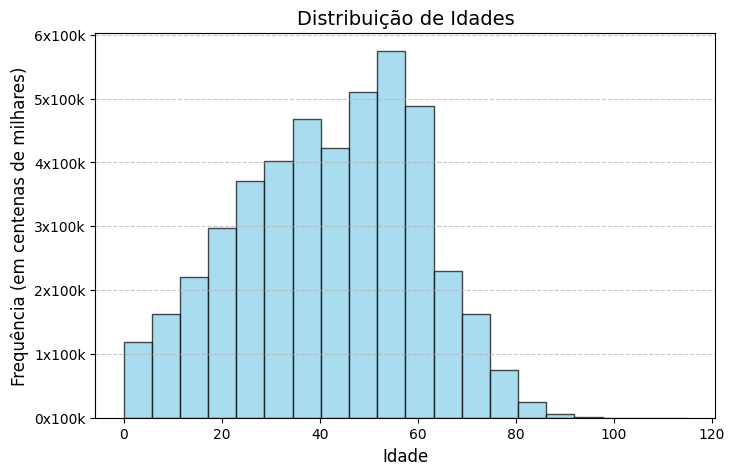

In [9]:
#CRIANDO HISTOGRAMA PARA AS IDADES DOS AGRICULTORES FAMILIARES
idades = df_membros["IDADE"]
plt.figure(figsize=(8, 5))  # Ajusta o tamanho do gráfico
plt.hist(idades, bins=20, color="skyblue", edgecolor="black", alpha=0.7)  # Personalização

# Ajustando o eixo Y para escala de 100.000
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/100000)}x100k'))

# Adicionando rótulos e título
plt.xlabel("Idade", fontsize=12)
plt.ylabel("Frequência (em centenas de milhares)", fontsize=12)
plt.title("Distribuição de Idades", fontsize=14)

# Adicionando uma grade
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Exibindo o gráfico
plt.show()

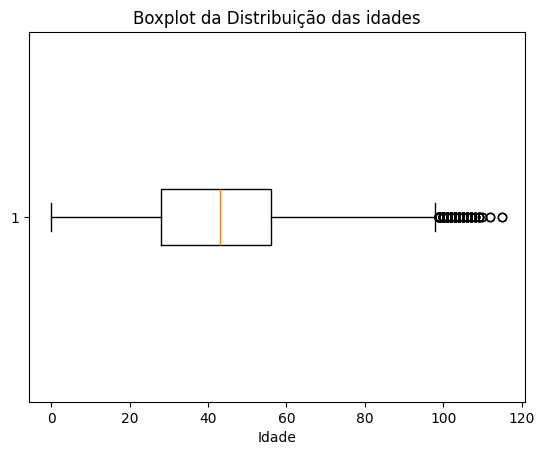

In [10]:
#CRIANDO UM BOXPLOT PARA VERIFICAR A DISTRIBUIÇÃO DOS DADOS E OUTLIERS
plt.boxplot(idades, vert=False)
plt.title("Boxplot da Distribuição das idades")
plt.xlabel("Idade")
plt.show()

<ipython-input-11-ed4693fc4e89>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='ESCOLARIDADE', data=df_membros, palette='pastel', edgecolor='black')


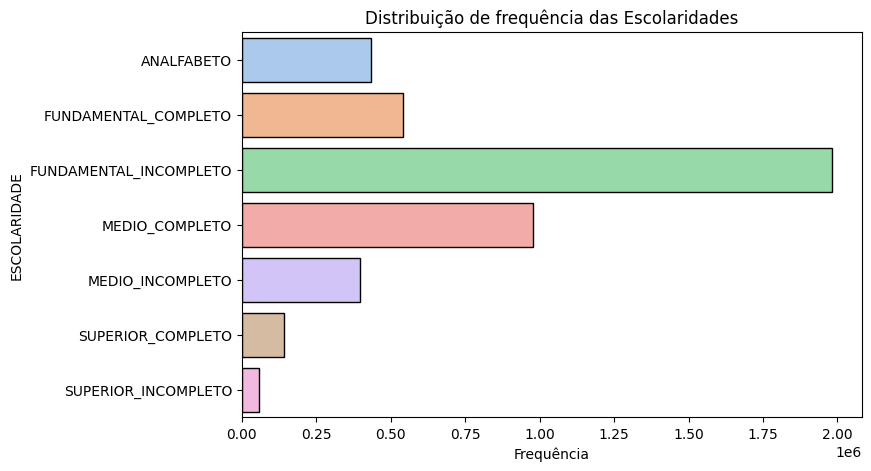

In [11]:
#GRÁFICO DE BARRAS PARA ESCOLARIDADE
plt.figure(figsize=(8, 5))

# Criando o gráfico de barras
sns.countplot(y='ESCOLARIDADE', data=df_membros, palette='pastel', edgecolor='black')
#plt.xticks(rotation=90)

# Personalizando
plt.ylabel('ESCOLARIDADE')
plt.xlabel('Frequência')
plt.title('Distribuição de frequência das Escolaridades')

plt.show()

<ipython-input-12-0620a5dbb9e2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='FAIXA_ETARIA', data=df_membros, palette='Purples', edgecolor='black')


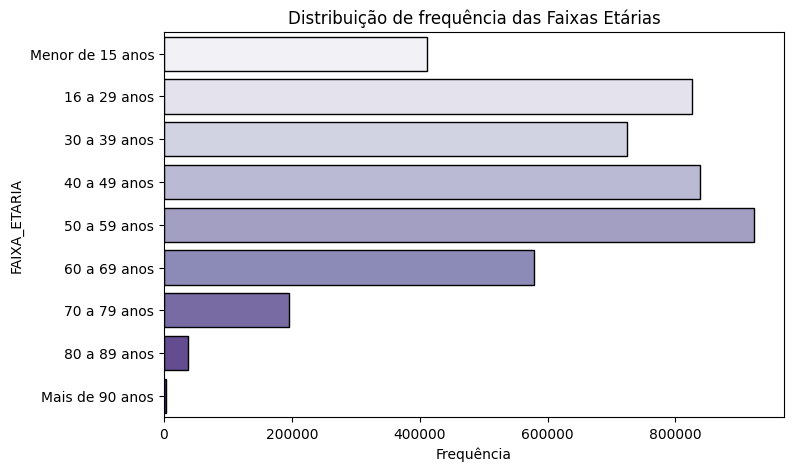

In [12]:
#GRÁFICO DE BARRAS PARA FAIXA ETÁRIA
plt.figure(figsize=(8, 5))

# Criando o gráfico de barras
sns.countplot(y='FAIXA_ETARIA', data=df_membros, palette='Purples', edgecolor='black')

# Personalizando
plt.ylabel('FAIXA_ETARIA')
plt.xlabel('Frequência')
plt.title('Distribuição de frequência das Faixas Etárias')

plt.show()

In [ ]:
# Carregando arquivo de ÁREA
df_area = pd.read_csv("/content/drive/My Drive/Colab Notebooks/MBA_Est_Desc_dados/AREA.csv", sep=';', encoding='utf-8', dtype={
    "CAF":"string",
    "UF":"string",
    "MUNICIPIO":"string",
    "IMOVEL_PRINCIPAL":"category",
    "USO_TERRA":"category"
    })



In [14]:
# Verificando se os dados foram importados corretamente (quantidade e formatos)
df_area.info()

#Verificando as informções importadas
df_area.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2587032 entries, 0 to 2587031
Data columns (total 5 columns):
 #   Column            Dtype   
---  ------            -----   
 0   CAF               string  
 1   UF                string  
 2   MUNICIPIO         string  
 3   IMOVEL_PRINCIPAL  category
 4   USO_TERRA         category
dtypes: category(2), string(3)
memory usage: 64.1 MB


,CAF,UF,MUNICIPIO,IMOVEL_PRINCIPAL,USO_TERRA
0,AC012023.01.000103697CAF,AC,PLÁCIDO DE CASTRO,SIM,PROPRIETÁRIO
1,AC012023.01.000103709CAF,AC,FEIJÓ,SIM,POSSEIRO/POSSUIDOR
2,AC012023.01.000103723CAF,AC,SENA MADUREIRA,SIM,ASSENTADO DA REFORMA AGRÁRIA
3,AC012023.01.000103941CAF,AC,TARAUACÁ,SIM,POSSEIRO/POSSUIDOR
4,AC012023.01.000103982CAF,AC,CRUZEIRO DO SUL,SIM,POSSEIRO/POSSUIDOR


In [15]:
# Transformando a variável UF → Região
uf_para_regiao = {
    'SP': 'Sudeste', 'RJ': 'Sudeste', 'MG': 'Sudeste', 'ES': 'Sudeste',
    'PR': 'Sul', 'SC': 'Sul', 'RS': 'Sul',
    'BA': 'Nordeste', 'PE': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste',
    'PB': 'Nordeste', 'RN': 'Nordeste', 'PI': 'Nordeste', 'AL': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'AC': 'Norte',
    'AP': 'Norte', 'TO': 'Norte'
}

# Criando a nova coluna "REGIÃO"
df_area['REGIAO'] = df_area['UF'].map(uf_para_regiao)

df_area.head()

,CAF,UF,MUNICIPIO,IMOVEL_PRINCIPAL,USO_TERRA,REGIAO
0,AC012023.01.000103697CAF,AC,PLÁCIDO DE CASTRO,SIM,PROPRIETÁRIO,Norte
1,AC012023.01.000103709CAF,AC,FEIJÓ,SIM,POSSEIRO/POSSUIDOR,Norte
2,AC012023.01.000103723CAF,AC,SENA MADUREIRA,SIM,ASSENTADO DA REFORMA AGRÁRIA,Norte
3,AC012023.01.000103941CAF,AC,TARAUACÁ,SIM,POSSEIRO/POSSUIDOR,Norte
4,AC012023.01.000103982CAF,AC,CRUZEIRO DO SUL,SIM,POSSEIRO/POSSUIDOR,Norte


In [16]:
# FAZENDO FILTRO NA VARIÁVEL DE INTERESSE
df_area_principal = df_area[df_area["IMOVEL_PRINCIPAL"] == "SIM"]

# VERIFICANDO QUANTAS UFPAs RESTARAM APÓS O FILTRO
df_area_principal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2365363 entries, 0 to 2587031
Data columns (total 6 columns):
 #   Column            Dtype   
---  ------            -----   
 0   CAF               string  
 1   UF                string  
 2   MUNICIPIO         string  
 3   IMOVEL_PRINCIPAL  category
 4   USO_TERRA         category
 5   REGIAO            object  
dtypes: category(2), object(1), string(3)
memory usage: 94.7+ MB


In [18]:
# JUNTANDO OS 2 DATAFRAMES PARA LOCALIZAR OS MEMBROS DAS UFPAs
# PEGANDO APENAS AS VARIÁVEIS DE INTERESSE NO DATAFRAME DE ÁREA

df_membros_area = pd.merge(df_membros, df_area_principal[["CAF", "UF", "MUNICIPIO", "REGIAO"]], on="CAF", how="inner")
df_membros_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4535535 entries, 0 to 4535534
Data columns (total 11 columns):
 #   Column                Dtype         
---  ------                -----         
 0   CAF                   string        
 1   CODIGO_PESSOA         string        
 2   SEXO                  category      
 3   DATA_NASCIMENTO       datetime64[ns]
 4   ESCOLARIDADE          category      
 5   MAO_DE_OBRA_FAMILIAR  category      
 6   IDADE                 int64         
 7   FAIXA_ETARIA          category      
 8   UF                    string        
 9   MUNICIPIO             string        
 10  REGIAO                object        
dtypes: category(4), datetime64[ns](1), int64(1), object(1), string(4)
memory usage: 259.5+ MB


In [ ]:
#TABELA DE FREQUENCIA CRUZADA DA VARIÁVEL FAIXA ETÁRIA E INFORMAÇÃO DE USO_TERRA
tabela_cruzada_2 = pd.crosstab(df_membros_area["FAIXA_ETARIA"], df_membros_area["USO_TERRA"], margins=True, margins_name="Total").sort_index()
print(tabela_cruzada_2)

In [ ]:
#Verificando a relação entre a faixa etária e uso da terra

# Criando a tabela de contingência
tabela_contingencia = pd.crosstab(df_membros_area["FAIXA_ETARIA"], df_membros_area["USO_TERRA"], margins=True, margins_name="Total").sort_index()

# Teste de Qui-Quadrado
chi2, p, dof, expected = chi2_contingency(tabela_contingencia)

print(f"Chi2: {chi2}")
print(f"Valor-p: {p}")
print(f"Graus de liberdade: {dof}")
print(f"Frequências esperadas: \n{expected}")

# Interpretando o valor-p
if p < 0.05:
    print("Existe uma relação significativa entre as variáveis.")
else:
   print("Não existe uma relação significativa entre as variáveis.")


In [ ]:
# Função para calcular o V de Cramér
def cramers_v(chi2, n, x, y):
    return np.sqrt(chi2 / (n * min(x - 1, y - 1)))

# Calcular o V de Cramér
n = tabela_contingencia.sum().sum()  # Total de observações
x = tabela_contingencia.shape[0]  # Número de linhas (categorias da variável 1)
y = tabela_contingencia.shape[1]  # Número de colunas (categorias da variável 2)

v = cramers_v(chi2, n, x, y)
print(f"V de Cramér: {v}")

In [15]:
# Carregando arquivo de RENDA
df_renda = pd.read_csv("/content/drive/My Drive/Colab Notebooks/MBA_Est_Desc_dados/RENDA.csv", sep=';', encoding='utf-8', dtype={
    "CAF":"string",
    "TIPO_RENDA":"string",
    "CATEGORIA_PRODUTO":"string",
    "PRODUTOL":"string",
    "VALOR_PRODUTO":"float"
}, decimal=",")

#Verificando a importação dos dados e variáveis
df_renda.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9177846 entries, 0 to 9177845
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CAF                string 
 1   TIPO_RENDA         string 
 2   CATEGORIA_PRODUTO  string 
 3   PRODUTO            object 
 4   VALOR_PRODUTO      float64
dtypes: float64(1), object(1), string(3)
memory usage: 350.1+ MB


In [30]:
df_renda_tipo = df_renda.groupby(['CAF', 'TIPO_RENDA'])['VALOR_PRODUTO'].sum().reset_index()
print(df_renda_tipo)

                              CAF                      TIPO_RENDA  \
0        AC012023.01.000103697CAF                 PRODUÇÃO ANIMAL   
1        AC012023.01.000103697CAF  RENDAS FORA DO ESTABELECIMENTO   
2        AC012023.01.000103709CAF            LAVOURAS TEMPORÁRIAS   
3        AC012023.01.000103709CAF                 PRODUÇÃO ANIMAL   
4        AC012023.01.000103709CAF  RENDAS FORA DO ESTABELECIMENTO   
...                           ...                             ...   
5526223  TO122024.01.002493568CAF  RENDAS FORA DO ESTABELECIMENTO   
5526224  TO122024.01.002494307CAF            LAVOURAS TEMPORÁRIAS   
5526225  TO122024.01.002494540CAF            LAVOURAS TEMPORÁRIAS   
5526226  TO122024.01.002494540CAF                 PRODUÇÃO ANIMAL   
5526227  TO122024.01.002494801CAF                           PESCA   

         VALOR_PRODUTO  
0             72000.00  
1             31512.00  
2             11400.00  
3            143400.00  
4             14400.00  
...                ..

In [31]:
#Criando um df com a area principal e rendas

df_renda_area = pd.merge(df_renda_tipo, df_area_principal, on="CAF", how="inner")
df_renda_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5526225 entries, 0 to 5526224
Data columns (total 7 columns):
 #   Column            Dtype   
---  ------            -----   
 0   CAF               string  
 1   TIPO_RENDA        string  
 2   VALOR_PRODUTO     float64 
 3   UF                string  
 4   MUNICIPIO         string  
 5   IMOVEL_PRINCIPAL  category
 6   USO_TERRA         category
dtypes: category(2), float64(1), string(4)
memory usage: 221.3 MB
